Compare several machine learning models on a performance metric

Perform hyperparameter tuning on the best model to optimize it for the problem

# Import

In [3]:
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib as ta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import Imputer, MinMaxScaler


csv_path = 'data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_featured.csv'
test_csv_path = 'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_featured.csv'

# Load data

In [4]:
test_df = pd.read_csv(test_csv_path,
                      header=0,
                      names=[
                          'time', 'open', 'high', 'low', 'close', 'volume',
                          'macd', 'macdsignal', 'macdhist', 'rsi', 'max_buy',
                          'max_buy_count', 'max_sell', 'max_sell_count',
                          'score'
                      ],
                      parse_dates=['time'])
time = pd.Series(test_df['time'])
hours = time.apply(lambda x: x.hour)
test_df['hour'] = hours

test_df.drop(columns=[
    'time', 'open', 'high', 'low', 'close', 'volume', 'max_buy',
    'max_buy_count', 'max_sell', 'max_sell_count'
],
             inplace=True)

df = pd.read_csv(csv_path,
                 header=0,
                 names=[
                     'time', 'open', 'high', 'low', 'close', 'volume', 'hour',
                     'volatility', 'macd', 'macdsignal', 'macdhist', 'rsi',
                     'max_buy', 'max_buy_count', 'max_sell', 'max_sell_count',
                     'score'
                 ],
                 parse_dates=True)
df.drop(columns=[
    'time', 'open', 'high', 'low', 'close', 'volume', 'volatility', 'max_buy',
    'max_buy_count', 'max_sell', 'max_sell_count'
],
        inplace=True)
df.tail()

,hour,macd,macdsignal,macdhist,rsi,score
374498,20,0.00004,0.00003,0.00001,57.93369,-2.47127
374499,20,0.00003,0.00003,0.00001,50.40028,-2.03363
374500,20,0.00002,0.00003,-0.00000,45.90079,2.17653
374501,20,0.00002,0.00003,-0.00000,52.43383,-2.17653
374502,20,0.00003,0.00003,0.00000,56.40269,-2.47127


# Remove outlier score

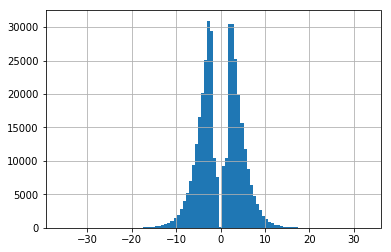

In [5]:
df['score'].hist(bins=100)

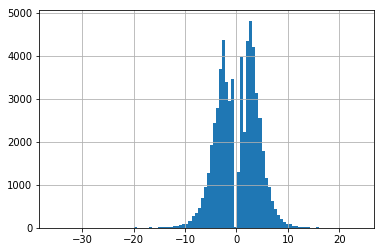

In [6]:
df[(df['hour'] > 18) & (df['hour'] < 23)]['score'].hist(bins=100)

93
103
374410


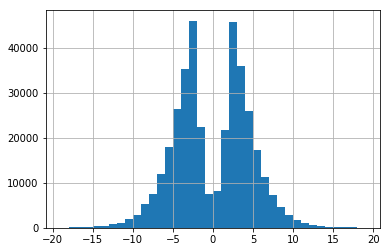

In [7]:
print(len(df[df['score'] > 19]))
print(len(df[df['score'] < -19]))

print(len(df[df['score'] < 19]))

# df.drop(df[df['score']>19].index,inplace=True)
df[(df['score'] < 19) & (df['score'] > -19)]['score'].hist(bins=38)

In [8]:
print(len(df))
df.drop(df[(df['score'] > 19) | (df['score'] < -19)].index, inplace=True)
print(len(df))

374503
374307


# Filter by scalping hours

In [9]:
test_df = test_df[(test_df['hour'] > 18) & (test_df['hour'] < 23)]
df = df[(df['hour'] > 18) & (df['hour'] < 23)]
test_df.drop(columns=['hour'], inplace=True)
df.drop(columns=['hour'], inplace=True)

df.head()

,macd,macdsignal,macdhist,rsi,score
1107,0.00030,0.00027,0.00003,60.00639,6.66841
1108,0.00028,0.00027,0.00001,60.20019,6.45415
1109,0.00028,0.00027,0.00000,62.17410,5.10763
1110,0.00029,0.00028,0.00002,67.24726,3.43575
1111,0.00031,0.00028,0.00003,68.94845,2.86231


# Extract labels

In [10]:
test_labels = test_df['score']
test_features = test_df.drop(columns=['score'])
train_labels = df['score']
train_features = df.drop(columns=['score'])
train_features.head()

,macd,macdsignal,macdhist,rsi
1107,0.00030,0.00027,0.00003,60.00639
1108,0.00028,0.00027,0.00001,60.20019
1109,0.00028,0.00027,0.00000,62.17410
1110,0.00029,0.00028,0.00002,67.24726
1111,0.00031,0.00028,0.00003,68.94845


# Scaling Features

In [11]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(train_features)

# Transform both the training and testing data
X = scaler.transform(train_features)
X_test = scaler.transform(test_features)

print(X.shape)
print(X_test.shape)

(62103, 4)
(13935, 4)


In [12]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
print(len(y))
print(len(y_test))

62103
13935


# Mean Absolute Error as criteria function

In [13]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

# Regression Models to Evaluate

In [14]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [15]:
# Linear regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)


Linear Regression Performance on the test set: MAE = 3.7289


In [16]:
# SVM

svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 3.6965


In [17]:
# Random forest

random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 3.9382


In [18]:
# Gradien boosted

gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 3.7433


In [19]:
# KNN

knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 3.7952


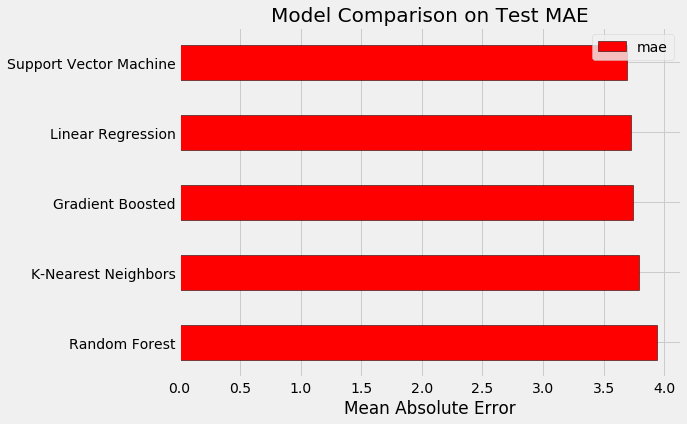

In [20]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

SVM is the best one, will select SVM to do Optimization and Hyperparameter Tuning.

# Model Optimization